In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from  scipy.stats  import norm

In [3]:
def generate_correlated_normals(n_sim, correlation):
    """
    Generates correlated normal random samples.

    Args:
    - n_sim (int): Number of simulations.
    - correlation (float): Correlation coefficient between two variables.

    Returns:
    - correlated_samples (numpy.ndarray): Array of correlated normal samples.
    """
    normal_samples = np.random.rand(2, n_sim)
    cov_matrix = np.array([[1, correlation], [correlation, 1]])
    cholesky_matrix = np.linalg.cholesky(cov_matrix)
    correlated_samples = np.dot(cholesky_matrix, normal_samples)
    return correlated_samples

def sim_bivariatemontecarlo(S0, variance, K, correlation=0.3, n_sim=1000):
    """
    Simulates a bivariate Monte Carlo experiment for a financial model.

    Args:
    - S0 (list): Initial stock prices for two assets.
    - variance (list): Variances of two assets.
    - correlation (float): Correlation coefficient between the asset returns.
    - n_sim (int): Number of Monte Carlo simulations.

    Returns:
    - payoffs (numpy.ndarray): Array of simulated payoffs.
    """
    payoffs = np.zeros(n_sim)
    stock = np.zeros((len(S0), n_sim))

    correlated_samples = generate_correlated_normals(n_sim, correlation)

    for j in range(n_sim):
        stock[0][j] = S0[0] * np.exp(variance[0] * correlated_samples[0][j])
        stock[1][j] = S0[1] * np.exp(variance[1] * correlated_samples[1][j])

        # Calculate the payoff as the maximum of the difference between the two asset prices and zero
        payoffs[j] = np.maximum(stock[0][j] - stock[1][j] - K, 0)

    return payoffs


def plot_simpayoffs(payoffs, mean_payoff):
    # Create a Seaborn histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(payoffs, bins=30, kde=True, color='blue')
    plt.xlabel("Payoff")
    plt.ylabel("Frequency")
    plt.title("Distribution of Option Payoffs")
    plt.axvline(x=mean_payoff, color='red', linestyle='--', label=f'Mean Payoff = {mean_payoff:.2f}')
    plt.legend()
    plt.grid(True)
    plt.show()

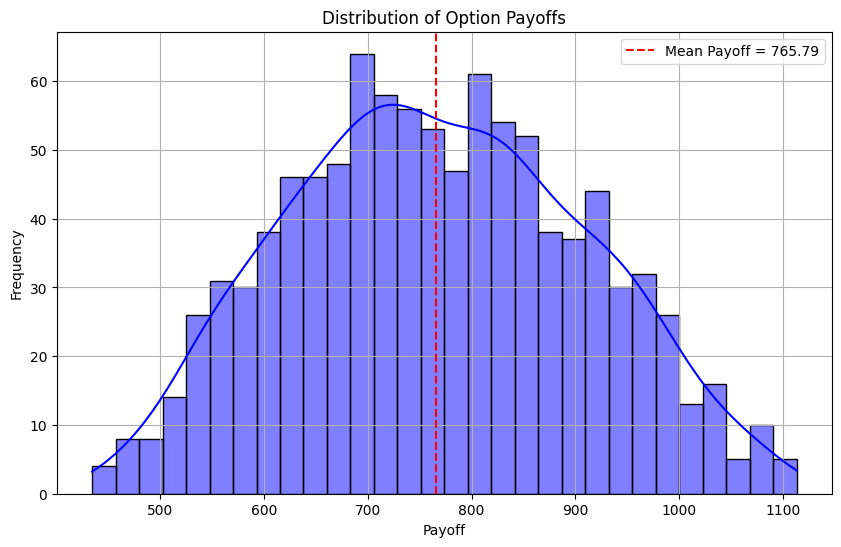

In [4]:
variance = [0.37, 0.54]
S1 = 100 * 11
S2 = 100 * 4

S = (S1, S2)
K = 0

payoffs = sim_bivariatemontecarlo(S, variance, K)
mean_payoff = np.mean(payoffs)
plot_simpayoffs(payoffs, mean_payoff)

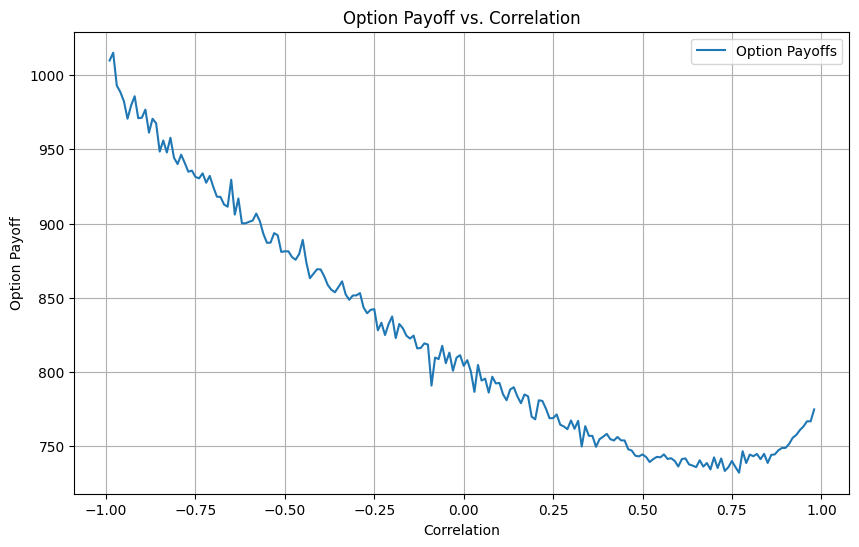

In [5]:
variance = [0.37, 0.54]
S1 = 100 * 11
S2 = 100 * 4
correlations = np.arange(start=-0.99,stop=0.99, step=0.01)
S = (S1, S2)

payoffs = []

for correlation in correlations: 
    payoffs.append(np.mean(sim_bivariatemontecarlo(S, variance, K, correlation=correlation)))

def plot_diffcorrelation_payoffs(payoffs):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=correlations, y=payoffs, label="Option Payoffs")
    plt.xlabel("Correlation")
    plt.ylabel("Option Payoff")
    plt.title("Option Payoff vs. Correlation")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_diffcorrelation_payoffs(payoffs)

In [6]:
def calc_portfoliovariance(correlation, variance, weights): 
    covariance = correlation * variance[0] * variance[1]
    portfolio_variance = (weights[0])**2 * variance[0]**2+ (weights[1])**2 * variance[1]**2 + 2 *weights[0]*weights[1] * covariance
    spread_volatility = np.sqrt(portfolio_variance)
    return spread_volatility

variance = [0.37, 0.54]
S1 = 100 * 11
S2 = 100 * 4
correlations = 0.3
weights = [1, -1]

spread_stdev = calc_portfoliovariance(correlation, variance, weights)
spread_stdev

0.19207290282598236

In [7]:
def calc_blackscholes(S0, stdev, r, T, t, K=0, option_type='EU_call'):
    d1 = 1 / (stdev * np.sqrt(T - t)) * (np.log(S0 / K) + (r + stdev**2 / 2) * (T - t))
    d2 = d1 - stdev * np.sqrt(T - t)

    if option_type == "EU_call":
        call_price = norm.cdf(d1) * S0 - norm.cdf(d2) * K * np.exp(-r * (T - t))
        return call_price

    elif option_type == "EU_put":
        put_price = K * np.exp(-r * (T - t)) * norm.cdf(-d2) - norm.cdf(-d1) * S0
        return put_price

    else:
        raise ValueError("Invalid option_type. Use 'EU-call' or 'EU-put'.")

S0 = 100
r = 0.0
T = 1.0
t = 0
K = S0
option_type = 'EU_call' 

calc_blackscholes(S0, spread_stdev, r, T, t, K, option_type)

7.650837769444507

Black Scholes: EU call price 0.0766260018567202


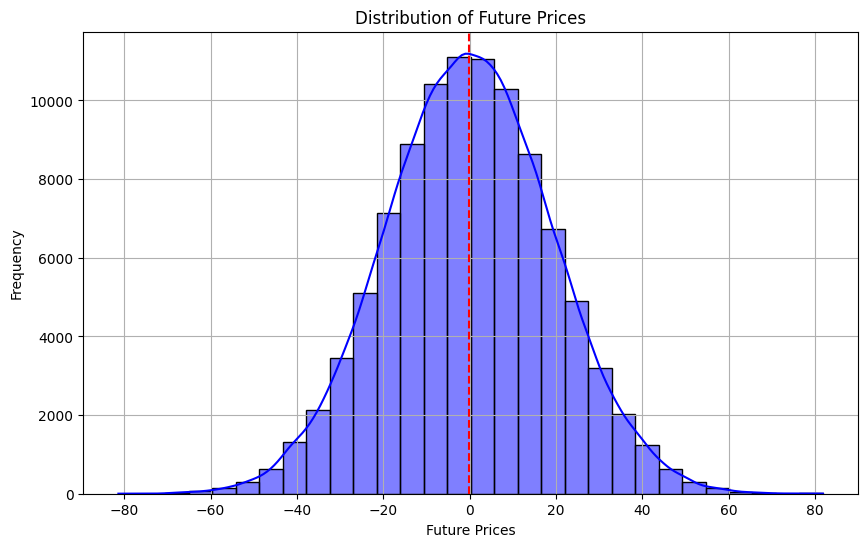

In [8]:
def sim_bachelierFuture(S0, stdev, T, n_sim = 100000):
    """
    Useful for assets whose prices can become negative, price distribution at maturity T is normal 
    """
    normal_samples = np.random.randn(n_sim)
    future_price = S0 * stdev * np.sqrt(T) * normal_samples

    return future_price


def calc_bacheliermodel(F, K, stdev, T, t, option_type="EU_call"):
    
    d1 = (F - K ) / (stdev * (T-t))
    if option_type == "EU_call":
        call_price = np.exp(-r*(T-t))*((F-K)*norm.cdf(d1))+(stdev*(T-t)/np.sqrt(2*np.pi)*np.exp(-d1**2/2))
        return call_price
    
    if option_type == 'EU_put':
        put_price = np.exp(-r*(T-t))*((K-F)*norm.cdf(-d1))+(stdev*(T-t)/np.sqrt(2*np.pi)*np.exp(-d1**2/2))
        return put_price

S0 = 100
T = 1.0
t = 0
mu = 0
r = 0

future_prices = sim_bachelierFuture(S0, spread_stdev, T)
mean_future_prices = np.mean(future_prices)
K = mean_future_prices

normal_blackscholes_callprice = calc_bacheliermodel(mean_future_prices, K, spread_stdev, T, t)
print(f"Black Scholes: EU call price {normal_blackscholes_callprice}")


def plot_histogramfutureprices(future_prices, mean_future):
    plt.figure(figsize=(10, 6))
    sns.histplot(future_prices, bins=30, kde=True, color='blue')
    plt.axvline(x=mean_future, color='red', linestyle='--', label=f'Mean Future = {mean_future:.2f}')
    plt.xlabel("Future Prices")
    plt.ylabel("Frequency")
    plt.title("Distribution of Future Prices")
    plt.grid(True)
    plt.show()

plot_histogramfutureprices(future_prices, np.mean(future_prices))

In [9]:
strike_prices = np.arange(0, S[0]-S[1], 1)
strike_prices = np.arange(0.001, 1000, 1)

# Moet dit dezelfde zijn als de spread deviation van de Bachelier simulatie
spread_stdev = calc_portfoliovariance(correlation, variance, weights)
S0=100

bs_discrepancies = []
bachelier_discrepancies = []


for strike_price in strike_prices:
    mc_payoffs = sim_bivariatemontecarlo(S, variance, K=strike_price)
    mc_option_price = np.mean(mc_payoffs)

    bs_option_price = calc_blackscholes(S0, spread_stdev, r, T, t, K=strike_price, option_type='EU_call')
    
    future_price = np.mean(sim_bachelierFuture(S0, spread_stdev, T))
    bachelier_option_price = calc_bacheliermodel(F=future_price, K=strike_price, stdev=spread_stdev, T=T, t=t, option_type='EU_call')

    bs_discrepancy = mc_option_price - bs_option_price
    bachelier_discrepancy = mc_option_price - bachelier_option_price

    bs_discrepancies.append(bs_discrepancy)
    bachelier_discrepancies.append(bachelier_discrepancy)

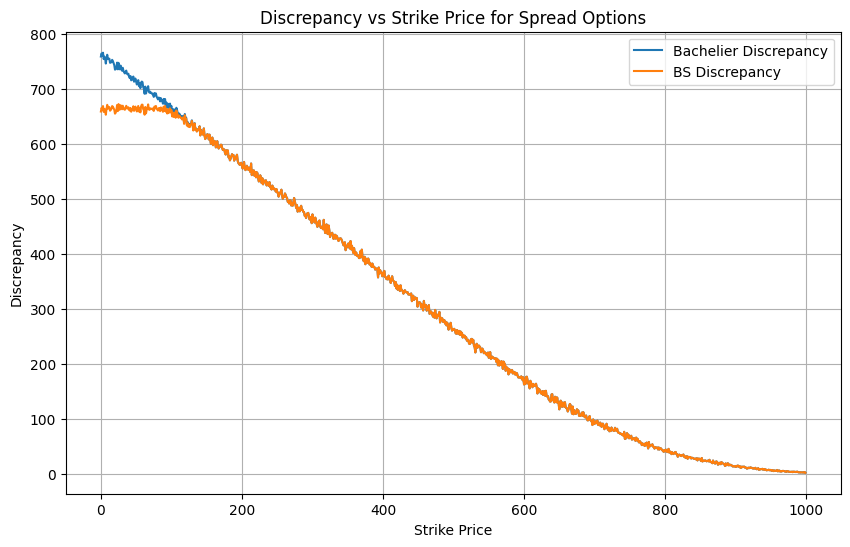

In [10]:
# Plot the discrepancies vs strike prices
plt.figure(figsize=(10, 6))
plt.plot(strike_prices, bachelier_discrepancies, label='Bachelier Discrepancy')
plt.plot(strike_prices, bs_discrepancies, label='BS Discrepancy')
plt.xlabel("Strike Price")
plt.ylabel("Discrepancy")
plt.title("Discrepancy vs Strike Price for Spread Options")
plt.legend()
plt.grid(True)
plt.show()